In [1]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA version used by PyTorch:", torch.version.cuda)
print("CUDA available?", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


PyTorch version: 2.5.1
CUDA version used by PyTorch: 11.8
CUDA available? True
Device: NVIDIA GeForce RTX 3060


c:\Users\Javier\anaconda3\envs\torch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Javier\.cache\kagglehub\datasets\ninadaithal\imagesoasis\versions\1
Subdirectorios encontrados en Data/: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Clases detectadas: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Using device: cuda
Época 1/10, Pérdida Entrenamiento: 0.3036, Pérdida Validación: 0.0673, Precisión Entrenamiento: 88.28%, Precisión Validación: 98.35%, Tiempo: 277.54s
Época 2/10, Pérdida Entrenamiento: 0.0528, Pérdida Validación: 0.0185, Precisión Entrenamiento: 98.09%, Precisión Validación: 99.36%, Tiempo: 246.67s
Época 3/10, Pérdida Entrenamiento: 0.0301, Pérdida Validación: 0.0037, Precisión Entrenamiento: 98.93%, Precisión Validación: 99.92%, Tiempo: 243.55s
Época 4/10, Pérdida Entrenamiento: 0.0244, Pérdida Validación: 0.0034, Precisión Entrenamiento: 99.15%, Precisión Validación: 99.94%, Tiempo: 256.25s
Época 5/10, Pérdida Entrenamiento: 0.0196, Pérdida Validación: 0.0016, 

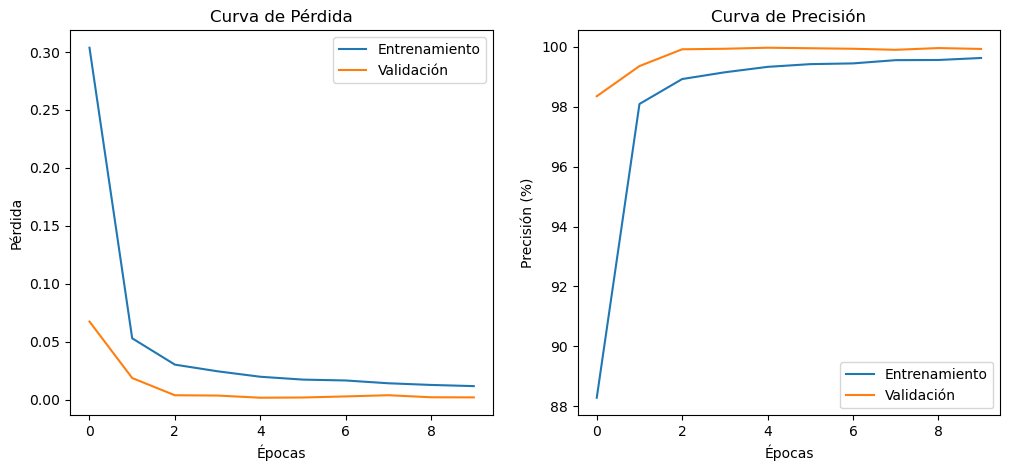

Reporte de clasificación:\n
                    precision    recall  f1-score   support

     Mild Dementia     0.9990    0.9990    0.9990       984
 Moderate Dementia     1.0000    0.9895    0.9947        95
      Non Demented     0.9993    0.9999    0.9996     13449
Very mild Dementia     0.9993    0.9971    0.9982      2760

          accuracy                         0.9993     17288
         macro avg     0.9994    0.9964    0.9979     17288
      weighted avg     0.9993    0.9993    0.9993     17288



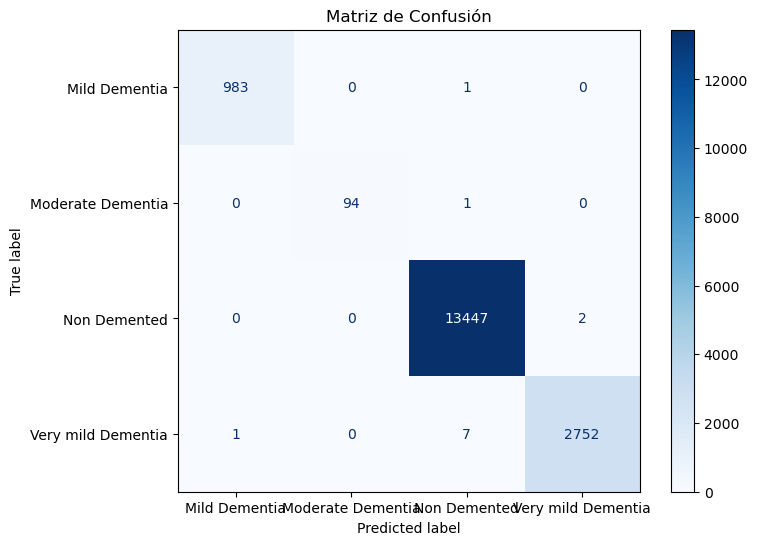

✅ Modelo congelado y guardado listo para backend


In [2]:
# ==============================
# 1. Importar librerías
# ==============================
import kagglehub
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
from PIL import Image

# ==============================
# 2. Descargar dataset
# ==============================
path = kagglehub.dataset_download("ninadaithal/imagesoasis")
print("Path to dataset files:", path)

# ==============================
# 3. Detectar estructura de carpetas
# ==============================
dataset_root = os.path.join(path, "Data")

subdirs = [d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))]
print("Subdirectorios encontrados en Data/:", subdirs)

# ==============================
# 4. Definir transformaciones
# ==============================
img_size = 128
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# ==============================
# 5. Manejo del dataset según estructura
# ==============================
if len(subdirs) > 1:
    # Caso normal: subcarpetas por clase (apto para ImageFolder)
    full_dataset = datasets.ImageFolder(dataset_root, transform=transform)
    print("Clases detectadas:", full_dataset.classes)
else:
    # Caso alternativo: todas las imágenes en una sola carpeta
    print("⚠️ Dataset no tiene subcarpetas por clase. Usando CustomDataset.")

    class CustomDataset(Dataset):
        def __init__(self, root, transform=None):
            self.root = root
            self.transform = transform
            self.samples = []

            for fname in os.listdir(root):
                if fname.lower().endswith((".jpg", ".png", ".jpeg")):
                    # Suponemos que el nombre del archivo contiene la clase (antes del primer _ o .)
                    label_name = fname.split("_")[0]
                    self.samples.append((os.path.join(root, fname), label_name))

            # Crear diccionario de etiquetas
            self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(set([s[1] for s in self.samples])))}
            self.classes = list(self.class_to_idx.keys())

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            path, label_name = self.samples[idx]
            image = Image.open(path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            label = self.class_to_idx[label_name]
            return image, label

    full_dataset = CustomDataset(dataset_root, transform=transform)
    print("Clases detectadas:", full_dataset.classes)

# ==============================
# 6. División train/val
# ==============================
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ==============================
# 7. Definición de modelo CNN
# ==============================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(), # Función de activación ReLU
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(), # Función de activación ReLU
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(), # Función de activación ReLU
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_size//8) * (img_size//8), 128),
            nn.ReLU(), # Función de activación ReLU
            nn.Dropout(0.3),
            nn.Linear(128, len(full_dataset.classes))
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = SimpleCNN(len(full_dataset.classes)).to(device)

# ==============================
# 8. Definir loss y optimizador
# ==============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==============================
# 9. Entrenamiento
# ==============================
num_epochs = 10 # <-- Aquí se indica el número de épocas
train_losses = [] # Lista para almacenar la pérdida de entrenamiento por época
val_losses = [] # Lista para almacenar la pérdida de validación por época
train_accuracies = [] # Lista para almacenar la precisión de entrenamiento por época
val_accuracies = [] # Lista para almacenar la precisión de validación por época


for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()


    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss) # Almacenar la pérdida de la época
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Evaluación en el conjunto de validación
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)


    elapsed_time = time.time() - start_time
    print(f"Época {epoch+1}/{num_epochs}, Pérdida Entrenamiento: {epoch_loss:.4f}, Pérdida Validación: {epoch_val_loss:.4f}, Precisión Entrenamiento: {train_accuracy:.2f}%, Precisión Validación: {val_accuracy:.2f}%, Tiempo: {elapsed_time:.2f}s")

print("Entrenamiento completado.")

# ==============================
# 10. Visualización de la pérdida
# ==============================
plt.figure(figsize=(12,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(train_losses, label='Entrenamiento')
plt.plot(val_losses, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de Pérdida')

# Precisión
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Entrenamiento')
plt.plot(val_accuracies, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión (%)')
plt.legend()
plt.title('Curva de Precisión')

plt.show()


# ==============================
# 11. Evaluación y métricas
# ==============================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Reporte de clasificación:\\n")
print(classification_report(y_true, y_pred, target_names=full_dataset.classes, digits=4))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
plt.figure(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues, values_format="d", ax=plt.gca())
plt.title("Matriz de Confusión")
plt.show()

# ==============================
# 12. Congelar y guardar el modelo entrenado
# ==============================
# Desactivar gradientes (ya no se entrenará más)
for param in model.parameters():
    param.requires_grad = False

model.eval()  # modo inferencia

# Guardar solo pesos (recomendado)
torch.save(model.state_dict(), "modelo_resonancias.pth")

# Opcional: exportar a TorchScript (más portable para backend)
example_input = torch.randn(1, 3, img_size, img_size).to(device)
traced_model = torch.jit.trace(model, example_input)
traced_model.save("modelo_resonancias_traced.pt")

print("✅ Modelo congelado y guardado listo para backend")


In [3]:
# ==============================
# Contar imágenes por carpeta
# ==============================
import os
import kagglehub

# Descargar dataset para asegurar que 'path' esté definido
path = kagglehub.dataset_download("ninadaithal/imagesoasis")


# Detectar estructura de carpetas (reutilizando el código inicial)
dataset_root = os.path.join(path, "Data")
subdirs = [d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))]


image_extensions = [".jpg", ".png", ".jpeg"]
image_counts = {}

for subdir in subdirs:
    subdir_path = os.path.join(dataset_root, subdir)
    count = 0
    if os.path.isdir(subdir_path):
        for fname in os.listdir(subdir_path):
            if any(fname.lower().endswith(ext) for ext in image_extensions):
                count += 1
    image_counts[subdir] = count

print("Número de imágenes por carpeta:")
for folder, count in image_counts.items():
    print(f"- {folder}: {count}")

Número de imágenes por carpeta:
- Mild Dementia: 5002
- Moderate Dementia: 488
- Non Demented: 67222
- Very mild Dementia: 13725


In [4]:
from PIL import Image
from torchvision import transforms
import torch

# Configuración
img_size = 128
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Ruta de la imagen
img_path = "C:/Users/Javier/Downloads/resonancia-magnetica-cerebro-comprar.jpg"

# Cargar imagen
image = Image.open(img_path).convert("RGB")
image = transform(image).unsqueeze(0)  # añadir dimensión batch

# Enviar a dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)

# Inferencia
model.eval()
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

print("Clase predicha:", predicted.item())


Clase predicha: 2
